In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob

sys.path.append('../code')
import utils
import anylogo
sns.set_style("whitegrid", {'axes.grid' : False})

In [95]:
# Load ratios
in_files_dict = {
    'lib_9nt':'../output/ratios_9nt_ss_lib.txt',
    'locus_9nt':'../output/ratios_9nt_ss_locus.txt',
    'lib_11nt':'../output/ratios_11nt_ss_lib.txt',
    'locus_11nt':'../output/ratios_11nt_ss_locus.txt',
    'lib_11to9nt':'../output/ratios_11nt_ss_lib_marg.txt',
    'locus_11to9nt':'../output/ratios_11nt_ss_locus_marg.txt'
}

matrix_dict = {}
psi_threshold = 20
cons_seq = 'CAGGUAAGU'

for name, in_file in in_files_dict.iteritems():
    print 'Processing %s...'%in_file
    
    df = pd.read_csv(in_file,sep='\t')
    df.set_index('ss',inplace=True,drop=True)
    site_length = len(df.index[0])    

    # Process each column
    col_dict = {}
    for col in df.columns:
        print 'Processing column %s...'%col
        tmp_df = df[[col]].dropna()
        
        # Normalize by consensus sequence
        if site_length==9:
            assert cons_seq in tmp_df.index
            cons_seq_val = tmp_df.loc[cons_seq,col]
                
        elif site_length==11:
            indices = [str(seq[:9])==cons_seq for seq in tmp_df.index]
            cons_seq_val = tmp_df.loc[indices,:].median()[0]
    
        else:
            raise Exception
            
        tmp_df.loc[:,col] = 100*tmp_df.loc[:,col]/cons_seq_val

        # Get list of sites above threshold
        indices = tmp_df[col] > psi_threshold
        sites = tmp_df.index[indices].tolist()
        if len(sites)==0:
            pdb.set_trace()
        assert len(sites) > 0
        assert len(sites[0]) == site_length

        # Fill counts matrix
        counts_matrix = np.zeros([site_length,4])
        bases = 'ACGU'
        for s in sites:
            for i in range(site_length):
                for b, base in enumerate(bases):
                    counts_matrix[i,b] += (s[i] == base)

        col_dict[col] = counts_matrix
    matrix_dict[name] = col_dict
print 'Done!'

Processing ../output/ratios_11nt_ss_lib_marg.txt...
Processing column brca2_11nt_lib1...
Processing column brca2_11nt_lib2...
Processing column brca2_11nt_lib3...
Processing ../output/ratios_9nt_ss_lib.txt...
Processing column brca2_9nt_lib1...
Processing column brca2_9nt_lib2...
Processing column ikbkap_9nt_lib1...
Processing column ikbkap_9nt_lib2...
Processing column smn1_9nt_lib1...
Processing column smn1_9nt_lib2...
Processing column smn1_9nt_lib3...
Processing ../output/ratios_11nt_ss_locus.txt...
Processing column brca2_11nt...
Processing ../output/ratios_11nt_ss_locus_marg.txt...
Processing column brca2_11nt...
Processing ../output/ratios_11nt_ss_lib.txt...
Processing column brca2_11nt_lib1...
Processing column brca2_11nt_lib2...
Processing column brca2_11nt_lib3...
Processing ../output/ratios_9nt_ss_locus.txt...
Processing column brca2_9nt...
Processing column ikbkap_9nt...
Processing column smn1_9nt...


In [118]:
# Define plots to make:
plots_dict = {
    'plot1_all_9nt_loci':[
        ('locus_9nt','brca2_9nt','Brca2'),
        ('locus_9nt','smn1_9nt','Smn1'),
        ('locus_9nt','ikbkap_9nt','Ikbkap'),
    ],
    'plot2_brca2_9nt_libs':[
        ('locus_9nt','brca2_9nt','Brca2 all'),
        ('lib_9nt','brca2_9nt_lib1', 'Brca2 lib1'),
        ('lib_9nt','brca2_9nt_lib2', 'Brca2 lib2'),
    ],
    'plot3_smn1_9nt_libs':[
        ('locus_9nt','smn1_9nt', 'Smn1 all'),
        ('lib_9nt','smn1_9nt_lib1', 'Smn1 lib1'),
        ('lib_9nt','smn1_9nt_lib2', 'Smn1 lib2'),
        ('lib_9nt','smn1_9nt_lib3', 'Smn1 lib3'),
    ],
    'plot4_ikbkap_9nt_libs':[
        ('locus_9nt','ikbkap_9nt', 'Ikbkap all'),
        ('lib_9nt','ikbkap_9nt_lib1', 'Ikbkap lib1'),
        ('lib_9nt','ikbkap_9nt_lib2', 'Ikbkap lib2'),
    ],
#     'plot5_brca2_11nt_libs':[
#         ('locus_11nt','brca2_11nt'),
#         ('lib_11nt','brca2_11nt_lib1'),
#         ('lib_11nt','brca2_11nt_lib2'),
#         ('lib_11nt','brca2_11nt_lib3'),
#     ],

}

----------------------------------------
plot1_all_9nt_loci


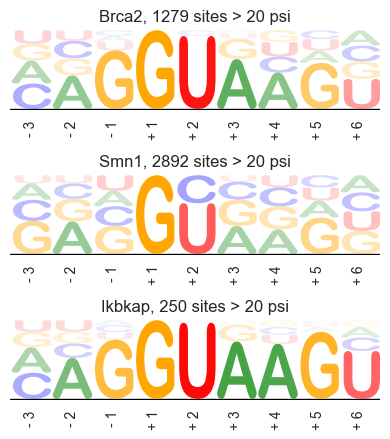

----------------------------------------
plot2_brca2_9nt_libs


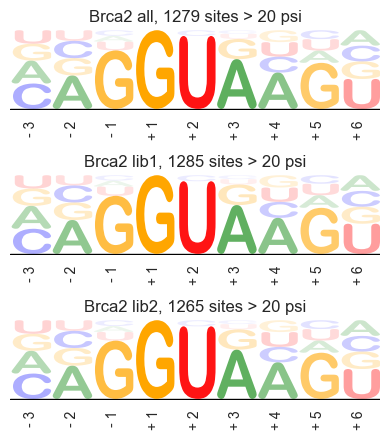

----------------------------------------
plot3_smn1_9nt_libs


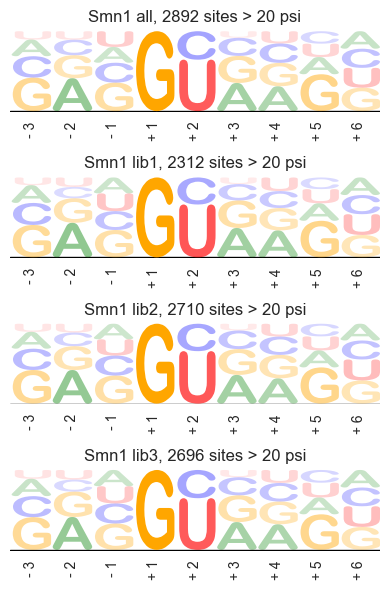

----------------------------------------
plot4_ikbkap_9nt_libs


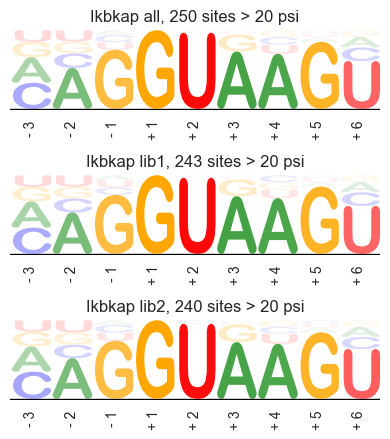

Done!


In [119]:
anylogo = reload(anylogo)

titles = plots_dict.keys()
titles.sort()

sign = lambda x: '+' if x > 0 else '-'

for title in titles:
    plots = plots_dict[title]
    num_motifs = len(plots)
    fig = plt.figure(figsize=[4,1.5*num_motifs])
    
    print '----------------------------------------'
    print title
    
    for n, (name, col, header) in enumerate(plots):
        
        # extract matrix
        col_dict = matrix_dict[name]
        matrix = col_dict[col]
        num_sites = matrix.sum(axis=1)[0]
        
        motif = pd.DataFrame(data=matrix,columns=list('ACGU'))
        motif.index.name = 'pos'
        site_length = motif.shape[0]
        pos_values = motif.index
        tmp = [-3,-2,-1]+range(1,site_length-2)
        pos_labels = ['%s %d'%(sign(x),abs(x)) for x in tmp]

        ax = fig.add_subplot(num_motifs,1,n+1)
        anylogo.draw(ax,prob_df=motif,logo_type='probability',\
                     use_transparency=True,floor_line_width=1, color_scheme='classic')
        clean_title = '%s, %d sites > %d psi'%(header,num_sites,psi_threshold)
        plt.title(clean_title)
        plt.xticks(pos_values, pos_labels)
        plt.xlabel('')
        plt.yticks([])
        plt.ylabel('')

    plt.tight_layout()
    plt.savefig('../plots/motifs.%s.pdf'%title)
    plt.show()

print 'Done!'